# Изучение особенностей задач поиска и локализации объектов на изображениях на основе библиотеки Detectron2

УСТАНОВКА ПАКЕТОВ


In [6]:
!pip install pyyaml==5.1

import torch

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION  = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=b049e69577cd565f7b66348ca43f1800c7b477ffdf7651001360144c3617dd17
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 763 kB/s 
     |████████████████████████████████| 74 kB 2.5 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 145 kB 30.5 MB/s 
     |████████████████████████████████| 130 kB 59.7 MB/s 
     |████████████████████████████████| 748 kB 52.6 MB/s 
     |███████████████████████████████

после установки необходимо будет перезапустить среду

Если у вас возникли проблемы с установкой, вы можете проверить правильность ссылки  установки для вашей версии `torch`, перейдя по ссылке https://detectron2.readthedocs.io/en/latest/tutorials/install.html
или используя официальный пример colab: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

## ИМПОРТ

In [1]:
import detectron2
import torch, torchvision

In [2]:
from pycocotools.coco import COCO
import os
from PIL import Image
import skimage.io as io

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os, json, cv2, random
from google.colab.patches import cv2_imshow

In [5]:
from detectron2        import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data             import MetadataCatalog, DatasetCatalog 
from detectron2.structures       import BoxMode
from detectron2.data.datasets    import register_coco_instances, load_coco_json
from detectron2.utils.logger     import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation       import COCOEvaluator, inference_on_dataset
from detectron2.data             import build_detection_test_loader

from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.data.datasets.coco import convert_to_coco_json

### Проверка весий

In [6]:
print(torch.__version__, torch.cuda.is_available())
!gcc --version


1.10.0+cu111 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [7]:
setup_logger()

<Logger detectron2 (DEBUG)>



---






посмотрим какие есть архитектуры

In [8]:
from detectron2.model_zoo.model_zoo import _ModelZooUrls
mz = _ModelZooUrls()
print("\t".join(list(mz.CONFIG_PATH_TO_URL_SUFFIX.keys())))

COCO-Detection/faster_rcnn_R_50_C4_1x	COCO-Detection/faster_rcnn_R_50_DC5_1x	COCO-Detection/faster_rcnn_R_50_FPN_1x	COCO-Detection/faster_rcnn_R_50_C4_3x	COCO-Detection/faster_rcnn_R_50_DC5_3x	COCO-Detection/faster_rcnn_R_50_FPN_3x	COCO-Detection/faster_rcnn_R_101_C4_3x	COCO-Detection/faster_rcnn_R_101_DC5_3x	COCO-Detection/faster_rcnn_R_101_FPN_3x	COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x	COCO-Detection/retinanet_R_50_FPN_1x	COCO-Detection/retinanet_R_50_FPN_3x	COCO-Detection/retinanet_R_101_FPN_3x	COCO-Detection/rpn_R_50_C4_1x	COCO-Detection/rpn_R_50_FPN_1x	COCO-Detection/fast_rcnn_R_50_FPN_1x	COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x	COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_1x	COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x	COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x	COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x	COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x	COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x	COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x	COCO-Insta

In [27]:
from google.colab import drive
drive.mount('/content/drive')
# !ls /content/drive/MyDrive/
%cd /content/
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content


In [28]:
import os
from pathlib import Path
import pandas as pd


In [29]:
os.chdir('/content/')
os.chdir(os.path.join(os.getcwd(),'drive','MyDrive','PitStonesData'))
print(os.getcwd())

/content/drive/MyDrive/PitStonesData


In [30]:
print(os.getcwd())
# print(os.listdir())

/content/drive/MyDrive/PitStonesData


In [31]:
path_2_datasets = os.getcwd()
list_datasets =os.listdir(path_2_datasets)
list_datasets

['asbestos_stone_lab_common_camera',
 'pits_stones_020221',
 'pits_stones_111121',
 'pits_stones_161120',
 'pits_stones_161220',
 'pits_stones_300920',
 'stones_transport',
 'output',
 'coco_eval',
 '.ipynb_checkpoints',
 'output1']

In [32]:
list_images = [os.path.join(path_2_datasets,data_pth,'images') for data_pth in list_datasets]
list_anno   = [os.path.join(path_2_datasets,data_pth,'annotations','instances_default.json') for data_pth in list_datasets]
# list_images, list_anno

In [33]:
def corret_coco_json_path(dataset_jsons,  path_imgs ):
    position_file_name =\
      dataset_jsons[0]['file_name'].find('/images/')
      
    not_correct_direcctory =\
      dataset_jsons[0]['file_name'][:int(position_file_name)+7] # 8 = len(/images/)
      
    for i in range(len(dataset_jsons)):
        dataset_jsons[i]['file_name'] = dataset_jsons[i]['file_name'].\
          replace(not_correct_direcctory,path_imgs).replace(':','_')
    
    return dataset_jsons

In [34]:
def check_class(dicts_json,class_id=0):
    cnt_json = 0
    for _ in range(len(dicts_json)):
        if len(dicts_json[cnt_json]['annotations'])<1:
            dicts_json.pop(cnt_json)
        else:
            cnt_id = 0
            for _ in range(len(dicts_json[cnt_json]['annotations'])):
                if dicts_json[cnt_json]['annotations'][cnt_id]['category_id'] not in class_id:
                    dicts_json[cnt_json]['annotations'].pop(cnt_id)
                else:
                    cnt_id +=1
            cnt_json +=1     
    return  dicts_json  

In [17]:
# def read_coco_datasets(list_images, list_anno, class_id=[0], verbose = True):

#     json_dicts = np.array([],dtype=object)

#     for i in range(len(list_anno)):
#         if os.path.exists(list_anno[i]) and os.path.exists(list_images[i]): 

#             dicts_json =\
#                   load_coco_json(json_file = list_anno[i], 
#                                 image_root = list_images[i], 
#                                 dataset_name = 'None',
#                                 extra_annotation_keys = None)

#             dicts_json = corret_coco_json_path(dicts_json, list_images[i])

#             dicts_json = check_class(dicts_json,class_id)

#             json_dicts = np.append(json_dicts,dicts_json)
#             if verbose:
#                 print(i, len(dicts_json))

#             # print(dicts_json[0]['file_name'],list_images[i] ,3*'\n')
#     return json_dicts

# json_dicts = read_coco_datasets(list_images[1:], list_anno[1:], verbose = True)

# print(json_dicts.shape)



In [35]:
def coco_datasets_info(list_images, list_anno):

    datasets_list = list()

    for i in range(len(list_anno)):

        if os.path.exists(list_anno[i]) and os.path.exists(list_images[i]): 


            dict_json =\
                  load_coco_json(json_file = list_anno[i], 
                                image_root = list_images[i], 
                                dataset_name = 'None',
                                extra_annotation_keys = None)
            dataset_info_dict = dict()      
            
            # if len(dict_json)>0:
 
                # dict_json = corret_coco_json_path(dict_json, list_images[i])

                # dict_json = check_class(dict_json,class_id)

            name_dataset = os.path.split(os.path.split(os.path.split(list_anno[i])[0])[0])[1]

            dataset_info_dict['name']   = name_dataset
            dataset_info_dict['length'] = len(dict_json)
            dataset_info_dict['anno_path'] = list_anno[i]
            dataset_info_dict['image_path'] = list_images[i]
            df = pd.DataFrame(dict_json)
            dataset_info_dict['height'] = list(set(df['height']))
            dataset_info_dict['width']  = list(set(df['width']))

            coco=COCO(list_anno[i], )
            cats = coco.loadCats(coco.getCatIds())
            class_id = [cat['id'] for cat in cats]
            class_names = [cat['name'] for cat in cats]

            dataset_info_dict['class_id']  = class_id
            dataset_info_dict['class_names']  = class_names

            dataset_info_dict['COCO_obj']  = coco

            datasets_list +=[dataset_info_dict]

    
    return datasets_list



In [36]:
coco_datasets_list = coco_datasets_info(list_images, list_anno)

[01/26 12:02:43 d2.data.datasets.coco]: Loaded 46 images in COCO format from /content/drive/MyDrive/PitStonesData/asbestos_stone_lab_common_camera/annotations/instances_default.json
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
[01/26 12:02:43 d2.data.datasets.coco]: Loaded 13 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_020221/annotations/instances_default.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[01/26 12:02:43 d2.data.datasets.coco]: Loaded 19 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_111121/annotations/instances_default.json
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
[01/26 12:02:43 d2.data.datasets.coco]: Loaded 68 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_161120/annotations/instances_default.json
loading annotations into memory...
Done (t=0.04s)
creating index.

In [37]:
coco_datasets_list

[{'COCO_obj': <pycocotools.coco.COCO at 0x7f4dfa0eac90>,
  'anno_path': '/content/drive/MyDrive/PitStonesData/asbestos_stone_lab_common_camera/annotations/instances_default.json',
  'class_id': [1, 2],
  'class_names': ['stone', 'asbest'],
  'height': [3456, 5184],
  'image_path': '/content/drive/MyDrive/PitStonesData/asbestos_stone_lab_common_camera/images',
  'length': 46,
  'name': 'asbestos_stone_lab_common_camera',
  'width': [5184, 3456]},
 {'COCO_obj': <pycocotools.coco.COCO at 0x7f4df69737d0>,
  'anno_path': '/content/drive/MyDrive/PitStonesData/pits_stones_020221/annotations/instances_default.json',
  'class_id': [1, 2],
  'class_names': ['stone', 'asbest'],
  'height': [2048],
  'image_path': '/content/drive/MyDrive/PitStonesData/pits_stones_020221/images',
  'length': 13,
  'name': 'pits_stones_020221',
  'width': [2592]},
 {'COCO_obj': <pycocotools.coco.COCO at 0x7f4df7897150>,
  'anno_path': '/content/drive/MyDrive/PitStonesData/pits_stones_111121/annotations/instances_def

In [38]:
def image_path_by_id(coco_dict,ids = [0]):
    dict_json =\
            load_coco_json(json_file = coco_dict['anno_path'], 
                          image_root = coco_dict['image_path'], 
                          dataset_name = 'None',
                          extra_annotation_keys = None)
            
    df = pd.DataFrame(dict_json)
    fnames = []
    print([gavno for gavno in np.atleast_1d(ids)])

    for im_id in np.atleast_1d(ids) :
        if im_id>0:
            fname = df[df["image_id"] == im_id]['file_name'].values 
            fnames +=[fname[0]]
    
    return fnames

file_paths = image_path_by_id(coco_datasets_list[1],[1,2])

file_paths


[01/26 12:02:48 d2.data.datasets.coco]: Loaded 13 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_020221/annotations/instances_default.json
[1, 2]


['/content/drive/MyDrive/PitStonesData/pits_stones_020221/images/asbestos/pits/020221/ManualGeneralImage_12_46_01.bmp',
 '/content/drive/MyDrive/PitStonesData/pits_stones_020221/images/asbestos/pits/020221/ManualGeneralImage_12_45_43.bmp']

pits_stones_111121
[01/26 12:47:15 d2.data.datasets.coco]: Loaded 19 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_111121/annotations/instances_default.json
[12]
/content/drive/MyDrive/PitStonesData/pits_stones_111121/images/ManualGeneralImage_12_55_46.bmp


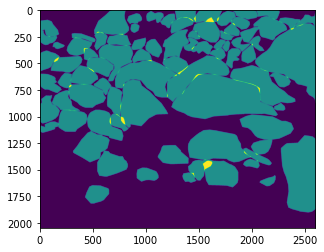

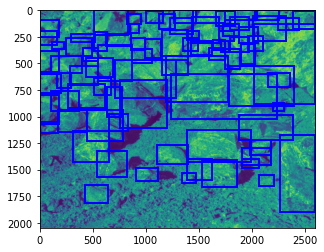

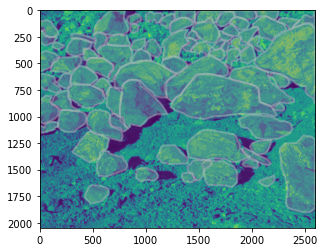

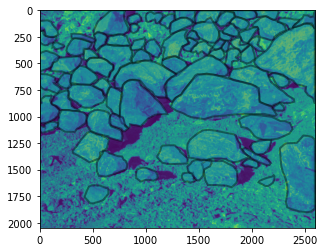

In [103]:
import matplotlib.patches as patches
import matplotlib
dataset_id = 2
image_id = 12

coco = coco_datasets_list[dataset_id]['COCO_obj']

print(coco_datasets_list[dataset_id]['name'])

image_path = image_path_by_id(coco_datasets_list[dataset_id],[image_id])[0]

print(image_path)


image = np.array(Image.open(image_path))

# https://stackoverflow.com/questions/50805634/how-to-create-mask-images-from-coco-dataset
img_info = coco.imgs[image_id]

# plt.imshow(image, cmap='gray'); plt.axis('off'); 

cat_ids = coco.getCatIds()


anns_ids = coco.getAnnIds(imgIds =image_id, catIds=1, iscrowd=None)


anns = coco.loadAnns(anns_ids) 

mask = np.zeros_like(image)
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask)
plt.show()

fig, ax = plt.subplots()
 
# Draw boxes and add label to each box
for ann in anns:
    box = ann['bbox']
    bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=2, edgecolor="blue", facecolor="none")
    ax.add_patch(bb)
 
ax.imshow(image)
plt.show()

fig, ax = plt.subplots()
 
# Draw boxes and add label to each box
# colors = list(matplotlib.colors.cnames.keys())
colors = ['red','blue','green','yellow','brown','black','wheat','pink','magenta','pink','purple','gold','lightslategray','silver','gray']
for ann in anns:
    
    color = np.random.choice(colors, 1)

    mask = np.asarray(ann['segmentation']).reshape(-1,2)

    bb = patches.Polygon(mask, linewidth=2, edgecolor="silver", facecolor='lightslategray',alpha=0.4)
    ax.add_patch(bb)
 
ax.imshow(image)
plt.show()

fig, ax = plt.subplots()

colors = ['red','blue','green']
for ann in anns:
    
    color = np.random.choice(colors, 1)

    mask = np.asarray(ann['segmentation']).reshape(-1,2)

    bb = patches.Polygon(mask, linewidth=2, edgecolor="black", facecolor=None,alpha=0.4)
    ax.add_patch(bb)
 
ax.imshow(image)
plt.show()




# plt.show()

In [83]:
import matplotlib.colors as mcolors
matplotlib.colors.to_rgba(list(matplotlib.colors.cnames.keys())[0])

(0.9411764705882353, 0.9725490196078431, 1.0, 1.0)

In [99]:
matplotlib.colors.cnames

{'aliceblue': '#F0F8FF',
 'antiquewhite': '#FAEBD7',
 'aqua': '#00FFFF',
 'aquamarine': '#7FFFD4',
 'azure': '#F0FFFF',
 'beige': '#F5F5DC',
 'bisque': '#FFE4C4',
 'black': '#000000',
 'blanchedalmond': '#FFEBCD',
 'blue': '#0000FF',
 'blueviolet': '#8A2BE2',
 'brown': '#A52A2A',
 'burlywood': '#DEB887',
 'cadetblue': '#5F9EA0',
 'chartreuse': '#7FFF00',
 'chocolate': '#D2691E',
 'coral': '#FF7F50',
 'cornflowerblue': '#6495ED',
 'cornsilk': '#FFF8DC',
 'crimson': '#DC143C',
 'cyan': '#00FFFF',
 'darkblue': '#00008B',
 'darkcyan': '#008B8B',
 'darkgoldenrod': '#B8860B',
 'darkgray': '#A9A9A9',
 'darkgreen': '#006400',
 'darkgrey': '#A9A9A9',
 'darkkhaki': '#BDB76B',
 'darkmagenta': '#8B008B',
 'darkolivegreen': '#556B2F',
 'darkorange': '#FF8C00',
 'darkorchid': '#9932CC',
 'darkred': '#8B0000',
 'darksalmon': '#E9967A',
 'darkseagreen': '#8FBC8F',
 'darkslateblue': '#483D8B',
 'darkslategray': '#2F4F4F',
 'darkslategrey': '#2F4F4F',
 'darkturquoise': '#00CED1',
 'darkviolet': '#9400D3

In [76]:
matplotlib.colors.CSS4_COLORS.keys()

dict_keys(['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lights

In [65]:
np.asarray(anns[i]['segmentation']).reshape(-1,2)

array([[692.4 , 518.43],
       [688.86, 557.41],
       [665.83, 575.12],
       [655.2 , 596.38],
       [648.11, 622.96],
       [628.63, 628.27],
       [548.9 , 591.07],
       [541.82, 587.53],
       [520.56, 585.75],
       [502.84, 582.21],
       [442.61, 536.15],
       [439.07, 511.35],
       [442.61, 490.09],
       [449.7 , 472.37],
       [469.18, 451.11],
       [506.39, 447.57],
       [550.68, 447.57],
       [573.71, 445.8 ],
       [602.05, 454.66],
       [635.71, 474.14],
       [658.74, 495.4 ]])

In [59]:
fig, ax = plt.subplots(figsize=(11,11))
 
# Draw boxes and add label to each box
for ann in anns:
    box = ann['bbox']
    bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=3, edgecolor="black", facecolor="none")
    ax.add_patch(bb)

plt.imshow(image, cmap='gray'); plt.axis('off');  plt.title('Object Detection', fontsize=40); plt.show()

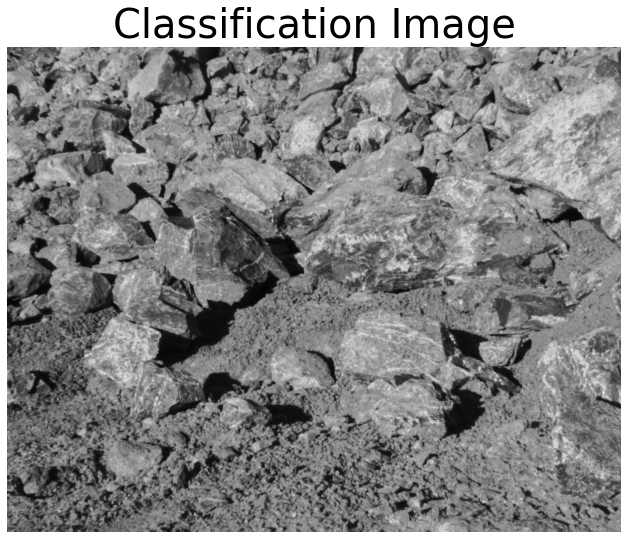

In [60]:
mask = np.zeros_like(image)
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

segm_mask = mask.copy()

segm_mask[segm_mask>0]=255


plt.figure(figsize=(11,11))
plt.imshow(segm_mask, cmap = 'gray'); plt.axis('off'); plt.title('Semantic segmentation', fontsize=40); plt.show()


mask = np.zeros_like(image)
for i in range(len(anns)):
    mask += 5*i*coco.annToMask(anns[i])


mask = mask/mask.max()

plt.figure(figsize=(11,11))
plt.imshow(mask, cmap = 'gray'); plt.axis('off'); plt.title('Instance segmentation ', fontsize=40); plt.show()

plt.figure(figsize=(11,11))
plt.imshow(image, cmap='gray'); plt.axis('off');  plt.title('Classification Image', fontsize=40); plt.show()



 


In [44]:

plt.figure(figsize=(11,11))




plt.imshow(out_
           , cmap='gray'); plt.axis('off');  plt.title('Image with mask', fontsize=48); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [23]:
import matplotlib as mpl
import matplotlib.colors as mplc

def draw_polygon(ax, segment, color, edge_color=None, linewidth=3):

    if edge_color is None:
        edge_color = color
    
    # edge_color = mplc.to_rgb(edge_color) + (1,)


    polygon = mpl.patches.Polygon(
        segment,
    )
    ax.add_patch(segment)
    return ax

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.imshow(image)

for i in range(len(anns)):
    # mask = coco.annToMask(anns[i])

    ax = draw_polygon(ax, np.asarray(anns[i]['segmentation']).reshape(-1,2), color=1, edge_color=None, linewidth=3)
plt.show()

NameError: ignored

In [ ]:
print(anns[i]['segmentation'])

print(np.asarray(anns[i]['segmentation']).reshape(-1,2))

In [24]:
def merge_dicts_2_array(json_dicts):
    json_array = np.array([],dtype=object)
    
    for dict_json in json_dicts.values():
        json_array = np.append(json_array,dict_json)
    
    return json_array


def read_from_coco_list(coco_datasets_list, class_id=[0], verbose = True):

    json_dicts = dict()

    for coco_dataset in coco_datasets_list:

            dict_json =\
                  load_coco_json(json_file = coco_dataset['anno_path'], 
                                image_root = coco_dataset['image_path'], 
                                dataset_name = 'None',
                                extra_annotation_keys = None)
            if len(dict_json)>0:
                dict_json = corret_coco_json_path(dict_json, coco_dataset['image_path'])

                dict_json = check_class(dict_json,class_id)

                name_dataset = coco_dataset['name']

                json_dicts[name_dataset]=dict_json

                if verbose:
                    print(name_dataset, len(dict_json))
    
    return json_dicts


def read_coco_datasets(list_images, list_anno, class_id=[0], verbose = True):

    json_dicts = dict()

    for i in range(len(list_anno)):
        
        if os.path.exists(list_anno[i]) and os.path.exists(list_images[i]): 

            dict_json =\
                  load_coco_json(json_file = list_anno[i], 
                                image_root = list_images[i], 
                                dataset_name = 'None',
                                extra_annotation_keys = None)
            if len(dict_json)>0:
                dict_json = corret_coco_json_path(dict_json, list_images[i])

                dict_json = check_class(dict_json,class_id)

                name_dataset = os.path.split(os.path.split(os.path.split(list_anno[i])[0])[0])[1]

                json_dicts[name_dataset]=dict_json

                if verbose:
                    print(i, len(dict_json))
    
    return json_dicts


In [25]:
# json_dicts = read_coco_datasets(list_images[1:], list_anno[1:], verbose = True)

json_dicts = read_from_coco_list(coco_datasets_list[1:])

print(json_dicts.keys())

print([len(json_dicts[i]) for i in json_dicts.keys()])

json_array = merge_dicts_2_array(json_dicts)

print(json_array.shape)

[01/26 12:01:04 d2.data.datasets.coco]: Loaded 13 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_020221/annotations/instances_default.json
pits_stones_020221 0
[01/26 12:01:04 d2.data.datasets.coco]: Loaded 19 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_111121/annotations/instances_default.json
pits_stones_111121 19
[01/26 12:01:04 d2.data.datasets.coco]: Loaded 68 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_161120/annotations/instances_default.json
pits_stones_161120 68
[01/26 12:01:04 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_161220/annotations/instances_default.json
pits_stones_161220 20
[01/26 12:01:04 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/drive/MyDrive/PitStonesData/pits_stones_300920/annotations/instances_default.json
pits_stones_300920 11
[01/26 12:01:04 d2.data.datasets.coco]: Loaded 134 

In [62]:
def train_test_coco_split(json_array, split_ratio = 0.7, random_shuffle=True):

    if random_shuffle:
        datasets = json_array[np.random.randint(low = 0, high= len(json_array), size =  len(json_array) ) ]
    else:
        datasets = json_array
    train = datasets[:int(len(json_array)*split_ratio)]
    test  = datasets[int(len(json_array)*split_ratio):]
    return train, test

train, val = train_test_coco_split(json_array, split_ratio = 0.7)

print(len(train), len(val) )


176 76


In [63]:
def register_json_array(json_array, dataset_name = 'test', class_label = ['1']):
    
    try:
      DatasetCatalog.remove(dataset_name)
    except:
        pass
    
    DatasetCatalog.register(dataset_name,  lambda: list(json_array) )

    MetadataCatalog.get(dataset_name).set(thing_classes=class_label)

    # convert_to_coco_json(dataset_name, output_file=os.path.join(os.getcwd(),dataset_name+'.json'), allow_cached=False)
    
    dataset_meta = MetadataCatalog.get(dataset_name)
    dataset_data = DatasetCatalog.get(dataset_name)

    return dataset_meta, dataset_data, dataset_name


dataset_train_meta, dataset_train_data,dataset_train_name = register_json_array(train, 'pitstone_train')
dataset_val_meta, dataset_val_data, dataset_val_name      = register_json_array(val, 'pitstone_val') 

print(dataset_train_name, len(dataset_train_data))
print(dataset_val_name,   len(dataset_val_data), )


pitstone_train 176
pitstone_val 76


In [81]:
def register_json_dicts(data_json_dicts, class_label = ['1']):
    dataset_names = []
    
    for dataset_name, data_dict  in zip(data_json_dicts.keys(), data_json_dicts.values()) :
         
        try:
          DatasetCatalog.remove(dataset_name)
        except:
            pass
        
        DatasetCatalog.register(dataset_name,  lambda: list(data_dict) )
        MetadataCatalog.get(dataset_name).set(thing_classes=class_label)
        
        dataset_names +=[dataset_name]
    
    return dataset_names



In [82]:
dataset_names = register_json_dicts(json_dicts, class_label = ['1'])
dataset_names

['pits_stones_020221',
 'pits_stones_111121',
 'pits_stones_161120',
 'pits_stones_161220',
 'pits_stones_300920',
 'stones_transport']

In [84]:
def get_dataset(dataset_name):

    dataset_meta = MetadataCatalog.get(dataset_name)
    dataset_data = DatasetCatalog.get(dataset_name)

    return dataset_meta, dataset_data

metas = []
datas = []
for dataset_name in dataset_names:
    meta_dataset,data_dataset = get_dataset(dataset_name)
    metas += [meta_dataset]
    datas += [data_dataset]

In [93]:
metas[1].get

Metadata(name='pits_stones_111121', thing_classes=['1'])

In [92]:
dataset_id = 2
image_id = 12

coco = coco_datasets_list[dataset_id]['COCO_obj']

print(coco_datasets_list[dataset_id]['name'], dataset_names[1])


dataset_meta, dataset_data = get_dataset(dataset_names[1])

visualizer = Visualizer(image, 
                        metadata=metas[6], 
                        scale=0.2,
                        instance_mode = ColorMode.IMAGE_BW)

out = visualizer.draw_dataset_dict(dataset_data[image_id])

plt.imshow(out.get_image());plt.show()


pits_stones_111121 pits_stones_111121


IndexError: ignored

In [79]:
out

In [73]:
def show_instance(dataset_instance, metadata = None, predictor=None, scale = 0.25, vebose = True):
    '''
    show data, meta_data and predicted values
    '''
    if vebose:
        print(dataset_instance["file_name"])
    
    
    img = cv2.imread(dataset_instance["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=metadata, 
                            scale=scale,
                            instance_mode = ColorMode.IMAGE_BW)

    #ORIGINAL    
    out = visualizer.get_output()
    print('\n ORIGINAL') 
    cv2_imshow(out.get_image()[:, :, ::-1])
    
    if metadata is not None:
        #GROUNDTRUCH
        out = visualizer.draw_dataset_dict(dataset_instance)
        print('\n GROUNDTRUCH')        
        cv2_imshow(out.get_image()[:, :, ::-1])

    #PREDICTED
    if predictor is not None:
        #I DO NOT KNOW WHY,
        # BUT IT IS NECESSARY TO CREATE NEW INSTANCE OF Visualizer
        visualizer = Visualizer(img[:, :, ::-1], 
                                metadata=metadata, 
                                scale=scale,
                                instance_mode = ColorMode.IMAGE_BW)  
      
        outputs = predictor(img[:, :, ::-1])

        out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

        print('\n PREDICTED')    
        cv2_imshow(out.get_image()[:, :, ::-1])

In [75]:
print(dataset_data[image_id])

show_instance(dataset_instance = dataset_data[image_id], 
              metadata  = dataset_meta, 
              predictor = None,                    
              scale     = 0.2)

{'file_name': '/content/drive/MyDrive/PitStonesData/stones_transport/images/12_12_02_34_16-03-2020_1.jpg', 'height': 2048, 'width': 2592, 'image_id': 12, 'annotations': [{'iscrowd': 0, 'bbox': [602.17, 318.17, 551.6999999999999, 687.9000000000001], 'category_id': 0, 'segmentation': [[739.75, 325.1, 835.05, 318.17, 888.76, 330.3, 925.15, 354.56, 978.86, 380.55, 1020.45, 401.34, 1039.51, 427.33, 1029.11, 453.32, 1032.58, 470.65, 1042.97, 503.57, 1055.1, 555.56, 1056.84, 598.87, 1084.56, 643.93, 1114.02, 671.65, 1122.68, 685.51, 1140.01, 734.03, 1152.14, 801.6, 1153.87, 832.79, 1131.34, 862.25, 1107.08, 905.57, 1063.77, 943.69, 1042.97, 948.89, 1025.65, 952.35, 973.14, 990.13, 923.93, 1006.07, 861.73, 996.02, 813.73, 983.02, 768.51, 962.92, 723.46, 946.98, 695.39, 920.82, 671.3, 886.85, 650.16, 852.72, 640.11, 807.5, 641.15, 773.53, 635.26, 747.37, 625.21, 720.34, 610.14, 686.2, 602.17, 663.16, 606.15, 600.09, 609.1, 559.89, 627.12, 523.85, 624.17, 489.71, 632.84, 432.7, 644.79, 406.37, 6


 GROUNDTRUCH


In [ ]:
MODEL_PATH =  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"

model_cfg    = model_zoo.get_config_file(MODEL_PATH)
weigths_init = model_zoo.get_checkpoint_url(MODEL_PATH)

cfg = get_cfg()
cfg.merge_from_file(model_cfg)

cfg.INPUT.CROP.ENABLED = True
cfg.INPUT.CROP.SIZE = [0.5,0.5]
cfg.INPUT.MASK_FORMAT = "polygon"  # alternative: "bitmask","polygon"


# dataset_train_meta, dataset_train_data = register_json(train, 'pitstone_train')
# dataset_val_meta, dataset_val_data = register_json(val, 'pitstone_val') 

cfg.DATASETS.TRAIN = ((dataset_train_name,)) #have to be a tuple!
cfg.DATASETS.TEST  = ((dataset_val_name,))


cfg.TEST.EVAL_PERIOD = 100

cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 2 #images per bath

cfg.SOLVER.BASE_LR         = 0.0002  # pick a good LR

cfg.SOLVER.MAX_ITER        = 100    

cfg.MODEL.WEIGHTS = weigths_init  

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 

#(see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
print(type(cfg), len(cfg))

#CREATE  FOLDER FOR RESULTS
os.makedirs(cfg.OUTPUT_DIR, 
            exist_ok=True)

<class 'detectron2.config.config.CfgNode'> 12


In [ ]:
from detectron2.modeling import build_model
model = build_model(cfg)  # returns a torch.nn.Module

RuntimeError: ignored

In [ ]:
from detectron2.checkpoint import DetectionCheckpointer

file_path_or_url  = os.path.join(os.getcwd(), 'output', 'model_final.pth')

DetectionCheckpointer(model).load(file_path_or_url)  # load a file, usually from cfg.MODEL.WEIGHTS

{'iteration': 99,
 'trainer': {'hooks': {'LRScheduler': {'base_lrs': [0.0002],
    'last_epoch': 99}},
  'iteration': 99}}

In [ ]:
# from detectron2.data import build_detection_train_loader

# data_loader = build_detection_test_loader(cfg,dataset_train_name )
# torch.cuda.empty_cache()
# for i, left in enumerate(data_loader):
#     print(i)
#     with torch.no_grad():
#         temp = model(left).view(-1, 1, 300, 300)
#     right.append(temp.to('cpu'))
#     del temp
#     torch.cuda.empty_cache()


In [ ]:
# https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=B4UESNQ4tyVm
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

# class CocoTrainer(DefaultTrainer):

#   @classmethod
#   def build_evaluator(cls, cfg, dataset_name, output_folder=None):

#     if output_folder is None:
#         os.makedirs("coco_eval", exist_ok=True)
#         output_folder = "coco_eval"

#     return COCOEvaluator(dataset_name, cfg, False, output_folder)

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)



# torch.cuda.empty_cache()

# trainer = CocoTrainer(cfg)
# trainer.resume_or_load(resume=True)
# trainer.train()

In [ ]:
checkpointer = DetectionCheckpointer(model, save_dir="output")
checkpointer.save("model_999")  # save to output/model_999.pth

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
show_instance(dataset_instance = dataset_val_data[0], 
              metadata  = dataset_val_meta, 
              predictor = predictor,                    
              scale     = 0.2) 

In [ ]:
len(dataset_val_data), dataset_val_name

(76, 'pitstone_val')

/content/drive/MyDrive/PitStonesData/pits_stones_161120/images/asbestos/pits/161120/637412004275790435.bmp

 ORIGINAL



 GROUNDTRUCH


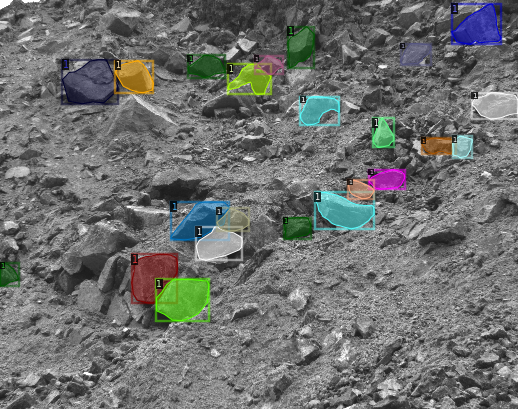

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride



 PREDICTED


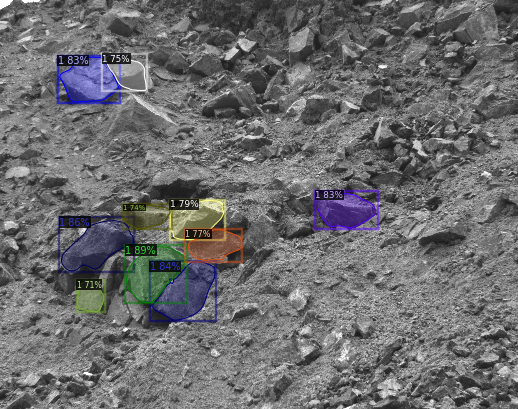

In [ ]:
rand_samples = np.random.randint(0,len(dataset_val_data),1)

for sample in rand_samples:

    show_instance(dataset_instance = dataset_val_data[sample], 
                  metadata  = dataset_val_meta, 
                  predictor = predictor,                    
                  scale     = 0.2) 

In [ ]:
evaluator  = COCOEvaluator(dataset_name = dataset_val_name, 
                           tasks        = ['segm'], 
                           distributed  = False, 
                           output_dir   = "./output1/")

[01/25 12:40:18 d2.evaluation.coco_evaluation]: Trying to convert 'pitstone_val' to COCO format ...
WARNING [01/25 12:40:18 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output1/pitstone_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.


In [ ]:
val_loader = build_detection_test_loader(cfg, dataset_val_name)

[01/25 12:40:20 d2.data.build]: Distribution of instances among all 1 categories:
| category   | #instances   |
|:-----------|:-------------|
| 1          | 2439         |
|            |              |
[01/25 12:40:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/25 12:40:20 d2.data.common]: Serializing 76 elements to byte tensors and concatenating them all ...
[01/25 12:40:20 d2.data.common]: Serialized dataset takes 1.24 MiB


In [ ]:

for dataset_name in dataset_names:
    print(5*'\n',dataset_name,5*'\n')
    evaluator  = COCOEvaluator(dataset_name = dataset_name, 
                              tasks        = ['segm'], 
                              distributed  = False, 
                              output_dir   = "./output1/")

    check_on_err_loader = build_detection_test_loader(cfg, dataset_name)

    print(inference_on_dataset(predictor.model, check_on_err_loader, evaluator))






 pits_stones_020221 





[01/25 12:40:24 d2.evaluation.coco_evaluation]: Trying to convert 'pits_stones_020221' to COCO format ...
WARNING [01/25 12:40:24 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output1/pits_stones_020221_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[01/25 12:40:24 d2.data.build]: Distribution of instances among all 1 categories:
| category   | #instances   |
|:-----------|:-------------|
| 1          | 1847         |
|            |              |
[01/25 12:40:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/25 12:40:24 d2.data.common]: Serializing 134 elements to byte tensors and concatenating them all ...
[01/25 12:40:24 d2.data.common]: Serialized dataset takes 1.19 MiB


NameError: ignored

In [ ]:
def predict_instance(dataset_instance, predictor=None, vebose = True):

    if vebose:
        print(dataset_instance["file_name"])

    img = cv2.imread(dataset_instance["file_name"])
 
    outputs = predictor(img[:, :, ::-1])

    return outputs
 

In [ ]:
for sample in rand_samples:

    res = predict_instance(dataset_instance = dataset_val_data[sample], 
                     predictor = predictor) 


/content/drive/MyDrive/PitStonesData/pits_stones_161120/images/asbestos/pits/161120/637412004275790435.bmp


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [ ]:
for instance in res['instances']:
    print(instance)

dict_keys(['instances'])

In [ ]:
dataset_val_data[sample]['file_name']

'/content/drive/MyDrive/PitStonesData/pits_stones_161120/images/asbestos/pits/161120/637412004275790435.bmp'

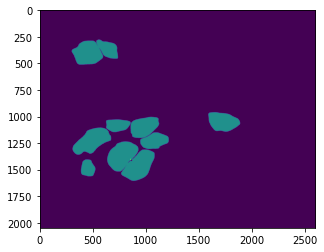

In [ ]:
masks = res['instances'].pred_masks.cpu().data.numpy()  # a tensor of shape (N, H, W)
mask_ =  masks.sum(axis=0)


plt.imshow(mask_[:,:]);plt.show()

[54048. 54356. 55825. 40198. 47917. 39610. 29215. 23434. 21225. 16439.]


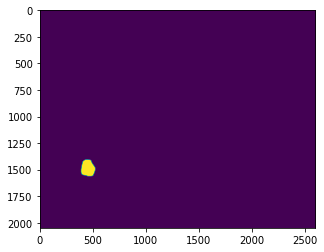

In [ ]:
areas = np.zeros(masks.shape[0])
for i,mask in enumerate(masks):
    areas[i] = np.sum(mask)
print(areas)  

plt.imshow(mask)

1

## Детекция изображений (Object Detection)

**Запустим на тесте - изображении из т.н. coco dataset**

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

Создадим конфигурацию для  detectron2 для модели по умолчанию `DefaultPredictor` для проверки работоспособности модели.

In [ ]:
cfg = get_cfg()

Загрузим кнофигурацию из готовых ```model_zoo``` например `faster rcnn` на основе энкодера `resnet 50` 

In [ ]:
config = model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")
cfg.merge_from_file(config)

Загрузим предобученную модель из набора готовых моделей ```model zoo```

In [ ]:
model_weights     =  model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")

cfg.MODEL.WEIGHTS = model_weights

И нам нужно указать порог достоверности для выхода сети

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 

загрузим конфигурацию в предиктор

In [ ]:
predictor = DefaultPredictor(cfg)


проверим как работает для загруженного изображения

построем предсказание

In [ ]:
outputs = predictor(im)

Проведем визуализацию предсказания


In [ ]:
v = Visualizer(im[:, :, ::-1], 
               MetadataCatalog.get(cfg.DATASETS.TEST[0]), 
               scale=1.2)

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

## Экземплярная сегментация (Instace Segmentation)

Теперь проверим тоже самое, но для instance segmentation

In [ ]:
MODEL = "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"

cfg          = get_cfg()
model_config  = model_zoo.get_config_file(MODEL)
model_weights =  model_zoo.get_checkpoint_url(MODEL)

cfg.merge_from_file(model_config)
cfg.MODEL.WEIGHTS = model_weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 
predictor = DefaultPredictor(cfg)
outputs   = predictor(im)

v = Visualizer(im[:, :, ::-1], 
               MetadataCatalog.get(cfg.DATASETS.TEST[0]), 
               scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Сегментация по ключевым точкам (Key Point Segmentation)

In [ ]:
MODEL = "COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"


# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

v = Visualizer(im[:,:,::1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::1])

## Пан-оптическая сегментация (Panoptic Segmentation)

In [ ]:
MODEL = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)

predictor = DefaultPredictor(cfg)

panoptic_seg, segments_info = predictor(im)["panoptic_seg"]

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)

cv2_imshow(out.get_image()[:, :, ::-1])



---




## **Тренировка ```MASK RCNN``` для задачи экземплярной сегментации** 






Рассмотрим задачу тренировки модели из набора, с 1 классом [the balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)

**Скачаем датасет и разархивируем его**

In [ ]:
# download, decompress the data
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
!unzip balloon_dataset.zip > /dev/null

Теперь надо [зарегистировать датасет](https://detectron2.readthedocs.io/tutorials/datasets.html) - то есть преобразовать его к внутренниму формату детектрона. Для этого используем следующую функцию.

*Следуе отметить, что для датасета формата ```COCO``` данная функция ненужна. ЕЕ можно заменить на следующую.*

```python
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "json_annotation_train.json","path/to/image/dir")
register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")
```


In [ ]:
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

Для двух каталогов train и val проведем регистрацию данных и методанных - их разметки.

!*Следует отметить, что в данном слаучае у нас нет тестового датасета - поэтому мы будем использовать валидационный датасет как тестовый, а валидировать будем на части тренировочного датасета(то есть он будет разбит на две части в рамках процедуры обучения!).*

In [ ]:
for d in ["train", "val"]:
    try:  
        DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    except:
         print('Probably data %s have been already registred'%d)

    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])

Теперь проверим что все прошло удачно - для этого загрузим одно случайное изображение и маску для него из тренировочного каталога



Для этого получим данные и методанные для тренировочного датасета

In [ ]:
balloon_metadata = MetadataCatalog.get("balloon_train")
dataset_dicts    = get_balloon_dicts("balloon/train")

теперь возьтем и посмотрим на 2 изображения

In [ ]:
for d in random.sample(dataset_dicts, 2):
    
    print(d)

    img = cv2.imread(d["file_name"])
    
    cv2_imshow(img) 
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.1)
    
    out = visualizer.draw_dataset_dict(d)
    
    cv2_imshow(out.get_image()[:, :, ::-1])

## Тренировка

Теперь проведем тренировку - дообучение instace segmentataion шариков  использованной ранее модели, обученной на датасете ```COCO``` 

$^*$ Может занять порядка 6 минут для 300 эпох.


Импорт функции тренировщика

In [ ]:
from detectron2.engine import DefaultTrainer

Настройка конфигурации тренировки
* Конфигурация на основе mask_rcnn_R_50_FPN_3x
* датасет ```balloon_train```
* число эпох 300
* батч 128 изображений
* число классов 1

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

Процедура тренировки

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

В случае необходимости посмотреть результаты тренировки разкомментируйте следующих код

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

### Оценка результатов обучения нейронной сети
Проведем оценку результатов обучения на валидационном наборе данных.

Для этого создадим объект - предсказатель, в котором используем результаты только что обученной модели.

$^*$ Конфигурация предсказателя должна быть основана на конфигурации для тренировки. Но в ней нужно добавить путь к обученным весам и выставить порог принятия решения об объекте (вероятность объекта не менее 70%).

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
predictor = DefaultPredictor(cfg)

Посмотрим, что получислось

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

Возьмем валидационный датасет

In [ ]:
dataset_dicts = get_balloon_dicts("balloon/val")

In [ ]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.25, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Проведем количественную оценку точности результатов обучения сети. Для этого используем метрику средняя точность (average precision, AP), а также оценим среднюю полноту результатов обучения (average recall, AR).

Создадим объект - оценка точности

In [ ]:
evaluator  = COCOEvaluator(dataset_name = "balloon_val", 
                           tasks        = ("bbox", "segm"), 
                           distributed  = False, 
                           output_dir   = "./output/")

Создадим объект загрузки датасета

In [ ]:
val_loader = build_detection_test_loader(cfg, "balloon_val")

In [ ]:
print(inference_on_dataset(trainer.model, val_loader, evaluator))

# another equivalent way to evaluate the model is to use `trainer.test`

### Упражнение 1.
1. Попробуйте обучить модель для задачи обнаружения окон и зданий по ссылке
https://github.com/InformationSystemsFreiburg/image_segmentation_japan/raw/master/buildings.zip
<!-- as hint you may use this link https://rosenfelder.ai/Instance_Image_Segmentation_for_Window_and_Building_Detection_with_detectron2/ -->
2. Попробуйте построить модель обнаружения объектов для набора данных люди на улицах, которую вы можете найти здесь:
https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
<!-- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html --><br>
*Примечание* набор имеет формат COCO

<!-- 
3. Try to build an instance segmentation model for the  blood cells dataset, that you may find here: https://public.roboflow.com/object-detection/bccd
<!-- as hint you may use this link https://blog.roboflow.com/how-to-train-detectron2/ 
*Note* you will need to register for download data, please download data in the COCO format
https://colab.research.google.com/drive/1-TNOcPm3Jr3fOJG8rnGT9gh60mHUsvaW#scrollTo=QvbWgc7HhfWi -->